# Predicting Crypto prices
1. Get historic stock prices
2. Extract prices to predict
3. Normalise
4. Create Time Series
5. Build model
6. Fit model
7. Test and evaluate

# X and Y
X = Goes back looking over a series of time e.g. past 7 minutes.<br>
Y = The last nth of the series of time e.g. the price of BTC on the 7th minute of the past 7 minutes.<br>

In [1]:
# Example
"""
look_back = 3
data = [1,2,4,5,7,8,9]

   X      Y
[1,2,4]->[5]
[2,4,5]->[7]
[4,5,7]->[8]
[5,7,8]->[9]
"""

'\nlook_back = 3\ndata = [1,2,4,5,7,8,9]\n\n   X      Y\n[1,2,4]->[5]\n[2,4,5]->[7]\n[4,5,7]->[8]\n[5,7,8]->[9]\n'

# Import dependencies

In [2]:
# install dependencies
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator

# Load dataset

In [3]:
data = pd.read_csv('../datasets/Daily/gemini_LTCUSD_day.csv')

# Explore dataset

In [4]:
data.head()

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
0,1644033600000,2022-02-05 04:00:00,LTCUSD,121.51,123.93,119.21,121.85,11120.25055
1,1643947200000,2022-02-04 04:00:00,LTCUSD,108.98,121.56,108.85,121.51,27101.62957
2,1643860800000,2022-02-03 04:00:00,LTCUSD,107.73,111.19,105.46,108.98,12407.62209
3,1643774400000,2022-02-02 04:00:00,LTCUSD,114.74,114.74,107.00,107.73,12103.81171
4,1643688000000,2022-02-01 04:00:00,LTCUSD,111.48,116.83,108.63,114.74,23140.65704


In [5]:
data.tail()

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
1204,1540008000000,2018-10-20 04:00:00,LTCUSD,51.88,52.75,51.88,52.75,1.000000
1205,1539921600000,2018-10-19 04:00:00,LTCUSD,51.88,51.88,51.88,51.88,0.000000
1206,1539835200000,2018-10-18 04:00:00,LTCUSD,53.52,53.87,51.25,51.88,3150.270139
1207,1539748800000,2018-10-17 04:00:00,LTCUSD,52.92,54.50,52.43,53.52,4206.391895
1208,1539662400000,2018-10-16 04:00:00,LTCUSD,0.00,55.20,0.00,52.92,5601.926989


In [6]:
data.columns

Index(['Unix Timestamp', 'Date', 'Symbol', 'Open', 'High', 'Low', 'Close',
       'Volume'],
      dtype='object')

In [7]:
data = data.drop(columns=['Unix Timestamp', 'Symbol', 'Open', 'High', 'Low', 'Volume'])

In [8]:
data.shape

(1209, 2)

In [9]:
data.describe()

,Close
count,1209.000000
mean,100.227353
std,66.257530
min,22.810000
25%,47.490000
50%,72.420000
75%,146.530000
max,409.760000


In [10]:
data.dtypes

Date      object
Close    float64
dtype: object

In [11]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_axis(data['Date'], inplace=True)
data.set_index('Date', inplace=True)

In [12]:
data.sort_index(inplace=True)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1209 entries, 2018-10-16 04:00:00 to 2022-02-05 04:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1209 non-null   float64
dtypes: float64(1)
memory usage: 18.9 KB


In [14]:
data

,Close
Date,
2018-10-16 04:00:00,52.92
2018-10-17 04:00:00,53.52
2018-10-18 04:00:00,51.88
2018-10-19 04:00:00,51.88
2018-10-20 04:00:00,52.75
...,...
2022-02-01 04:00:00,114.74
2022-02-02 04:00:00,107.73
2022-02-03 04:00:00,108.98


# Data visualisation

In [15]:
import matplotlib.pyplot as plt

In [16]:
data['Close']

Date
2018-10-16 04:00:00     52.92
2018-10-17 04:00:00     53.52
2018-10-18 04:00:00     51.88
2018-10-19 04:00:00     51.88
2018-10-20 04:00:00     52.75
                        ...  
2022-02-01 04:00:00    114.74
2022-02-02 04:00:00    107.73
2022-02-03 04:00:00    108.98
2022-02-04 04:00:00    121.51
2022-02-05 04:00:00    121.85
Name: Close, Length: 1209, dtype: float64

In [17]:
data_close = data['Close'].values
data_close

array([ 52.92,  53.52,  51.88, ..., 108.98, 121.51, 121.85])

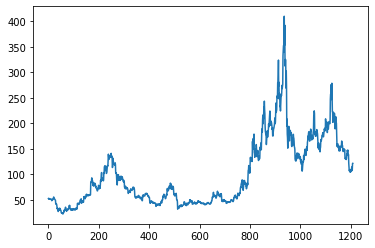

In [18]:
data_close = data_close.reshape((-1, 1))
plt.plot(data_close)
plt.show()

# Split data into train and test

In [19]:
train_size = int(len(data_close) * 0.8) # 80% of data will be for training

data_train = data_close[:train_size]
data_test = data_close[train_size:] # the rest will be for testing

print('Train data size: ', len(data_train))
print('Test data size: ', len(data_test))

Train data size:  967
Test data size:  242


# Create time series out of data

In [20]:
look_back = 15 # look back to the past 60 minutes (one hour) of the prices

train_generator = TimeseriesGenerator(data_train, data_train, length=look_back, batch_size=64)     
test_generator = TimeseriesGenerator(data_test, data_test, length=look_back, batch_size=1)

# Set up and build LSTM model

In [21]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import L2

In [22]:
# initialise model
model = Sequential()
# add layers
model.add(LSTM(50, activation='relu', input_shape=(look_back, 1), recurrent_dropout=0.2))
model.add(Dense(1))
# compile model
model.compile(loss='mse', optimizer='adam')

In [23]:
# fit the model
num_epochs = 20
model.fit(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/20
15/15 [==============================] - 2s 9ms/step - loss: 10714.1699
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 5851.9028
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1410.0155
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 1300.1350
Epoch 5/20
15/15 [==============================] - 0s 9ms/step - loss: 1308.5173
Epoch 6/20
15/15 [==============================] - 0s 9ms/step - loss: 1335.5339
Epoch 7/20
15/15 [==============================] - 0s 9ms/step - loss: 1539.1967
Epoch 8/20
15/15 [==============================] - 0s 9ms/step - loss: 1892.3060
Epoch 9/20
15/15 [==============================] - 0s 9ms/step - loss: 1761.4126
Epoch 10/20
15/15 [==============================] - 0s 9ms/step - loss: 1578.0480
Epoch 11/20
15/15 [==============================] - 0s 10ms/step - loss: 1720.1310
Epoch 12/20
15/15 [==============================] - 0s 9ms/step - loss: 2406.4136
Epoch 13/20

In [24]:
prediction = model.predict(test_generator)

data_train = data_train.reshape((-1))
data_test = data_test.reshape((-1))
prediction = prediction.reshape((-1))

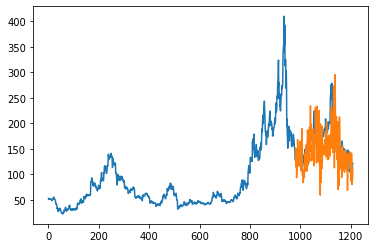

In [25]:
# Plot the predictions on a graph
prediction_plot = np.empty_like(data_close.reshape((-1)))
prediction_plot[:] = np.nan
prediction_plot[(len(data_train) + look_back):] = prediction

plt.plot(data_close)
plt.plot(prediction_plot)
plt.show()

# Make forecast

In [26]:
data_close = data_close.reshape((-1))

def predict(num_prediction, model):
    prediction_list = data_close[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list

num_prediction = 100
forecast = predict(num_prediction, model)

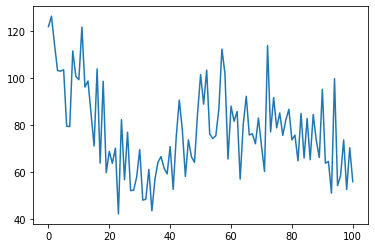

In [27]:
forecast = forecast.reshape((-1))
plt.plot(forecast)
plt.show()

In [28]:
data_forecast = np.append(data_close, forecast)

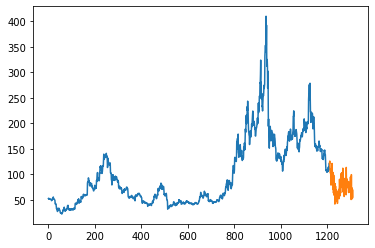

In [29]:
# Plot the forec on a graph
forecast_plot = np.empty_like(data_forecast)
forecast_plot[:] = np.nan
forecast_plot[len(data_close):] = forecast

plt.plot(data_close)
plt.plot(forecast_plot)
plt.show()